--- 
Project Microeconometrics | Summer 2020, M.Sc. Economics, University of Bonn | [Vincent Selz](https://github.com/VincentSelz)

# Replication of “A Structural Analysis of Disappointment Aversion in a Real Effort Competition” by David Gill and Victoria Prowse (2012) <a class="tocSkip"> 
---

There are four ways to view this notebook:

Aside, from the accompanying text, the results are labelled into three categories:

<div class="alert alert-block alert-success">
    <b>Successful replication:</b> All the results are replicated.
</div>
<div class="alert alert-block alert-warning">
    <b>Imperfect replication:</b> Only parts of the results are replicated.
</div>
<div class="alert alert-block alert-info">
    <b>Extension:</b> The results of the paper are expanded.
</div>

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

from linearmodels.panel import RandomEffects
from linearmodels.panel import PanelOLS
from linearmodels.panel import FirstDifferenceOLS
import numpy as np
import pandas as pd
import pandas.io.formats.style
import respy as rp
import scipy.stats as stats
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import matplotlib as plt
import matplotlib.pyplot as pyplt
from IPython.display import HTML
from IPython.display import display

from auxiliary.overview import *
from auxiliary.msm import *
from auxiliary.helper import *

pd.set_option("display.precision", 3)
pd.set_option('display.max_colwidth', -1)

/Users/vincentselz/opt/anaconda3/lib/python3.7/site-packages/respy/_numba.py:2: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.cgutils', please update to use 'numba.core.cgutils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba import cgutils


In [27]:
%%R

library(plm)
library(haven)
library(msm)
library(stargazer)
library(car)

---
# 1. Introduction 
---
Gill & Prowse (2012) use a real effort tournament in an laboratory experiment to test experimentally whether agents are disappointment averse. Pairs of subjects need to complete the real effort task sequentially. The payoff is determined in a lottery, where the probababilities of winning are linear in the difference in the agent's efforts. Hence, in the standard framework, the effort of the *First Mover* should not impact the choice of effort for the *Second Mover*. Yet, as predict by Gill & Prowse's model of disappointment aversion, subjects exhibit a discouragement effect, where high effort by the *First Mover*, impacts the effort by the *Second Mover* negatively. Their effort choices are strategic substitutes.

To estimate possible effects. First Gill & Prowse (2012) use a reduced form **random effects panel regression**. Given the substantial variation induced by their experimental design, they use the **Method of Simulated Moments (MSM)** to estimate the parameters of a structural model of disappointment aversion. This structural models allows them to estimate the strength of disappointment aversion on average but also to estimate the extent of heterogeneity in disappointment aversion across the population. 

This notebook will attempt to replicate the results of Gill & Prowse (2012) and will further add robustness to the findings by Gill & Prowse (2012). If possible Python is used to replicate the findings, yet if not possible R is used. For instance, the **random effects regression** with the common Python packages did yield close results but did not reproduce the same numbers, the authors use in their paper. 

In the following section, the experimental design is shown. Next, the identification strategy is discussed, followed by the theoretical predictions. Then, the empirical analysis and extension thereof are shown. Extensions are marked by blue boxes. Lastly, the paper will be critically assessed.

---
# 2. Experimental Design
---
The six experimental session took place from late February to early March 2009 at the Nuffield Centre for Experimental Social Sciences (CESS) in Oxford. Per session twenty subjects participated at the study, leading to a subject pool of 120 participants in total. Each of the were paid a show-up fee of 4 pounds and went on to earn a further 10 pounds on average.  

## Slider Task 

The slider task consists of a single screen displaying numerous sliders. The number and position of sliders is not varied across subjects or across repetition of the task. At first, the sliders who range from 0 to 100 are placed at 0. It is possible to place the slider at every integer position between 0 and 100. The integer position is displaced next to the slider. The sliders can be adjusted and readjusted an unlimited number of times. The task for the subjects is to position as many sliders as possible at 50 during the time allocated to the subject. The number of sliders positioned at 50 constitutes the **points score**. The number of correctly placed sliders and the time remaining is displayed to the subject. In this experiment, 48 sliders were displayed and the subjects had 120 seconds to position them. 

<img src="files/ProwseGillSliderTask.png">

## Experimental Procedure

Each session consists of 10 *First Mover* and 10 *Second Mover*, who stay in their role for the duration of their session. After two practice rounds, the subjects played 10 paying rounds. The prize for each pair was drawn randomly from {0.10,0.20,...3.90} and then revealed to the pair members. The task was completed sequentially, where the *Second Mover* observes the **points score** of the *First Mover*. This information is also displayed next to the alloted time and the own points score during the task. The probability to win the ensuing lottery is determined by

\begin{equation*}
P_i(e_i,e_j) = \frac{e_i + e_j + 50}{100}
\end{equation*}

were the $e_i$ in this setting corresponds to the **points score** of player $i$, and respectively $e_j$ for player $j$.[^1]

After each round the subjects were paired with another subjects. To ensure that subjects never meet each other, the *'no contagion'* matching algorithm of Cooper et al. (1996) is used. This prevents strategic action by the subjects.

[^1]: The use of the term effort in the paper is unlike the traditional understanding, where effort is the associated cost of an action. Here, it directly corresponds to the behavior. 

---
# 3. Theoretical Predictions
---

The paired subjects compete with each other to win a fixed prize $v$. The first subject chooses his effort and then the second mover chooses his effort. Together the above stated probability to winning prize $v$ is determined. The probabilities are linear in the difference of points scores. For their analysis, the authors only focus on the Second Mover. This leaves them with a pure optimization problem.    

## Canonical Model

For the canonical model to work, the separability assumption common in tournament literature is used. The assumption states that the utility $U_{2}$ can be separated into the *material utility* $u_{2}(y_{2})$ and the cost of effort $C(e_{2})$. This implies cost of effort does not depend on whether the agent wins the prize and the valuation of the prize does not change with increasing effort. Thus , this leaves the agent with the expected utility:

\begin{equation*}
EU_2(e_2,e_1) = P_2(e_2,e_1)u_2(v) + (1 - P_2(e_1,e_2)) u_2(0) - C_2(e_2)
\end{equation*}

Because of the linearity of the winning probabilities in the difference of efforts, the effort $e_1$ of the First Mover's has no impact on the Second Mover's effort $e_2$. This leads to the proposition:

**PROPOSITION 1:** *In the canonical model without disappointment aversion the Second Mover’s optimal effort $e_2$ (or set of optimal efforts) does not depend on the First Mover’s effort $e_1$.*

Given this relative lack of further structural assumption makes this model flexible. For instance, the results still holds when risk aversion, inequity aversion (Fehr and Schmidt 1999) or a fixed reference point are webbed into the utility function. 

## Disappointment Aversion

The basis of this model of disappointment aversion is that agents are sensitive to deviations from their expectations.  They suffer a psychological loss when they receive less than what they expect and elation when they receive more. These potential losses and gains, in turn, inform the agent in his/her decision process. **Here could an example do wonders.** 

The agent compares the material utility $u_2(y_2)$ to a reference point $R_2$. Experiencing a loss when the material utility is less than the reference point and elation when the material utility is above this reference level.  Without further assumption on the form of this Reference Point $R_2$, this leaves the agent with the following utility

\begin{equation*}
U_2(e_2,R_2,e_1) = u_2(y_2) + I_{u_2(y_2) \geq R_2}G_2(u_2(y_2) - R_2) + I_{u_2(y_2) \leq R_2}L_2(u_2(y_2) - R_2) - C_2(e_2)
\end{equation*}

The loss function $L_2(x)$ is strictly negative for all $x < 0$ and the gain function is $G_2(x) \geq 0$ for $x > 0$. Loss aversion dictates that $G_2(x) < |L_2(-x)|$ for all $x > 0$. The losses are more painful than equal-sized gains are pleasurable. Traditionally, this reference point is given exogenously. Yet, such a fixed reference point does not link the First Mover effort to the Second Mover effort. To model disappointment aversion the reference point must be formed endogenously. Köszegi and Rabin (2007) propose a *choice-acclimating* reference point, where the reference point is equal to the expected utility. The reference point is dependent on the effort of both the Second Mover him/herself and the First Mover's effort. Unlike the model by Köszegi and Rabin, hen optimizing his/her behavior the Second Mover is aware that his/her effort choice affects the reference point. In this setting this leads to $R_2 = vP_2(e_2,e_1)$.

As is custom in the literature piece-wise linearity is imposed on the gain-loss utility. $l_2$ is the slope of the loss function and $g_2$ is the slope of the gain function. Loss aversion imposes $l_2 > g_2$ and leads to the (strictly positive) definition of the strength of disappointment aversion

\begin{equation*}
\lambda_2 \equiv l_2 - G_2$.
\end{equation*}

Thus, the disappointment averse expected utility can be formulated as 

\begin{equation*}
EU_2(e_2,e_1) = P_2 v + g_2(v - vP_2) + (1 - P_2)(0 + l_2(0 + vP_2) - C_2(e_2) \\
= vP_2 + \lambda_2vP_2(1 - P_2) - C_2(e_2) 
\end{equation*}

The extra term in the middle of the equation is coined the **disappointment deficit** by the authors. This disappointment deficit is proportional to the variance of the Second Mover's two-point distribution of monetary payoffs. Due to disappointment aversion, the Second Mover dislikes variance in his/her monetary payoff. This is a key distinction to risk aversion, where agents only care about their probability of winning and not about the variance in their potential payoffs. This variance is strictly concave and maximized at $P_2$. When the efforts yield a zero probability for the Second Mover to win, he/she has a reference point of zero and combined with the probability he/she can never be disappointed. Yet at this point, small increases in probability lead to large increases in the variance of monetary payoffs. These increases get smaller but continue until $P_2 = \frac{1}{2}$. At this point the variance reaches its highest point. From this point on increases in $P_2$ reduce the variance of monetary payoffs. This relationship can expressed as: 

**PROPOSITION 2:** *When the Second Mover is disappointment averse, higher First Mover effort discourages the Second Mover: the Second Mover’s optimal effort $e_2$ is always (weakly) decreasing in the First Mover’s effort $e_1$.*

In order to derive an analytical expression, the authors assume a quadratic cost of effort of the form 

\begin{equation*}
C_2(e_2) = be_2 + \frac{ce_{2}^{2}}{2}.
\end{equation*}

With this term the Second Mover's reaction function this leads to 

**PROPOSITION 3:** *Suppose a disappointment averse Second Mover has a quadratic cost function and a strictly concave objective function, i.e., $\gamma_2c_2 − \lambda_2v > 0$. When the action space is continuous, the slope of the Second Mover’s reaction function in the interior is given by*

\begin{equation*}
\frac{de_2}{de_1} = \frac{-\lambda_2v}{2\gamma^2c - \lambda_2v} < 0.
\end{equation*}

*which becomes strictly more negative in the strength of disappointment aversion $\lambda_2$ and the value of the prize $v$. When the action space is discrete, the discrete analog of the reaction function behaves similarly.*



---
# 4. Identification Strategy
---

The advantages of an experiment are evident in the identification strategy of the authors. We can assume that the effort of the Second Mover's $e_2$ is affected by the value of the prize $v$, the effort of the First Mover $e_1$. In addition to that there can be learning throughout the ten played periods. Strictly speaking this term is inaccurate, since it actually captures to very different ideas of learning. First, the learning of the Slider Task, where the agent improves his/her performance by experience. But second, there can be meta-learning, where the agent gets more selective under which conditions he/she exerts effort. 

![ERROR:Something went wrong. Here should be a causal graph](files/AdvancedCausalGraph.png)

As the experimenters have total control of the environmental variables, they can randomize all those links, making for a straightforward identification strategy. The prizes are drawn from a uniform distribution between 0.10 and 3.90 Pounds. This variation also has advantages in the construction of structural equations as will be seen later. The ten rounds make it possible to control for individual specific effects and the matching algorithm ensures that there is no feedback back from the Second Mover effort to the First Mover, eliminating possible strategic interaction. The learning effect can be - imperfectly - controlled for with round dummies.    

---
# 5. Empirical Results
---
## Data Exploration

Before we are turning to the empirical strategies to estimate the strength of disappointment aversion, we can visually inspect the data to see why the authors pursue their identification strategy. The data consists of 120 subjects, 60 First and 60 Second Mover that are all observed over 10 rounds. Of the 120 subjects, one subject failed to correctly position any slider during the training or playing rounds. The dataset excluding this subject is called **df_2_pref** and is used mainly for the analysis. The points score is interpreted as the effort choice by the subject. Although still discrete, this gives them a finely gradated measure of effort.

The variable of interest is the Second Mover's effort and, thus, the authors are performing a conditional analysis of the Second Mover's effort choice. Their reasoning is that this analysis is sufficient for the puropose of identfying and estimating the strength of siappointment aversion. Including the First Mover's effort would make further assumptions necessary and increase the computational complexity substantially. 

<div class="alert alert-block alert-success">
    <b>Replication</b> of Table 1 of the paper.
</div>

In [3]:
df_1, df_2, df_2_pref = get_datasets()
rslt = effort_overview(df_2_pref)
rslt

,Mean E1,SD E1,Mean E2,SD E2,Min E1,Min E2,Max E1,Max E2
period,,,,,,,,
1,22.034,5.991,21.763,6.101,1,0,33,34
2,22.627,6.708,23.458,4.836,0,11,33,33
3,24.763,6.075,24.831,4.875,0,12,37,38
4,24.627,5.956,25.203,4.502,0,16,35,36
5,24.966,6.800,25.119,5.660,0,0,36,35
6,24.729,7.508,24.898,7.039,1,0,37,39
7,25.881,5.855,25.763,6.109,9,0,37,37
8,26.831,5.858,26.169,5.133,9,14,41,35
9,25.593,8.550,26.254,6.702,0,0,38,40


One important inferences that can be made is that the maximum of effort is 41 correctly positioned sliders. This is lower than the highest possible maximum of 48 sliders. If, subjects reached these limits, this would suggest that the task is not suited to identify exerted effort. Another inferences is that the effort choices increase over the rounds, suggesting that learning indeed takes place. 

<div class="alert alert-block alert-info">
<b>Note:</b> The following graphs and charts are extensions of the paper.
</div>

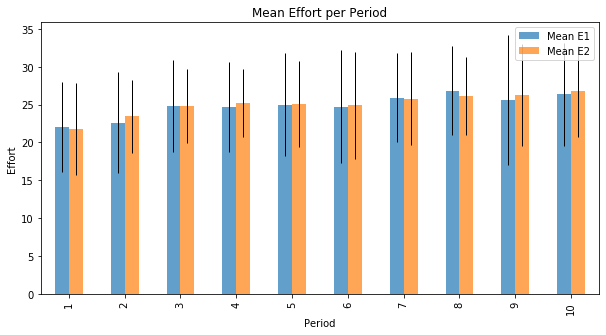

In [4]:
effort_chart(rslt)

This chart visualizes Table 1 of the paper. The black bar is indicating the standard deviation of the respective means. Clearly, there appears to be no clear distinction between $e_2$ and $e_1$, when simply inspecting these descriptives. 

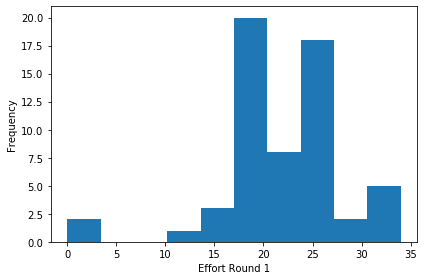

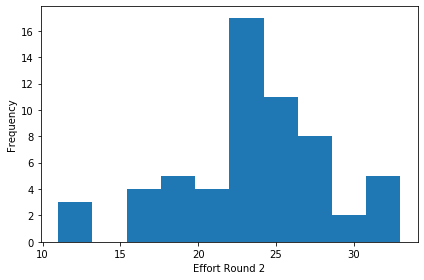

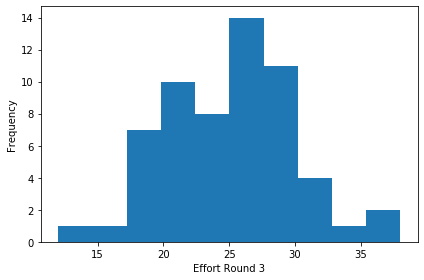

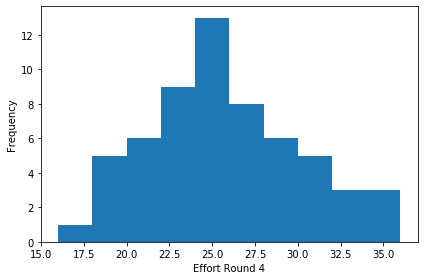

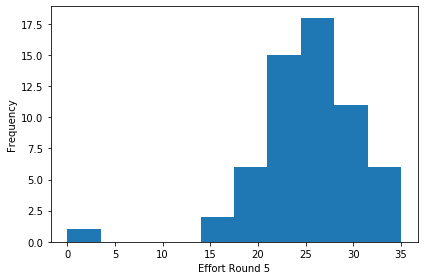

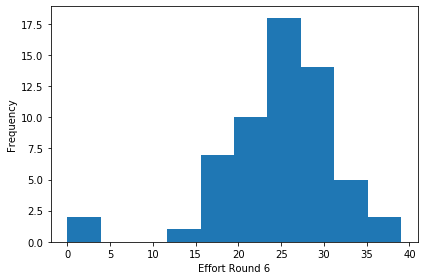

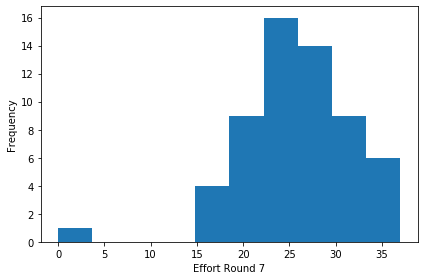

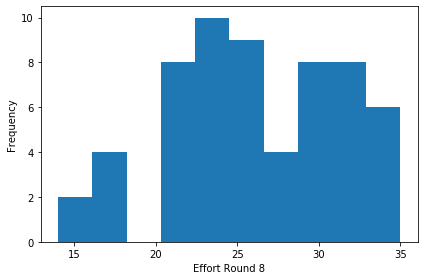

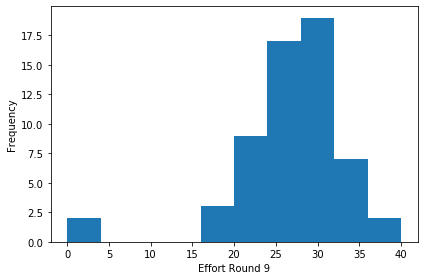

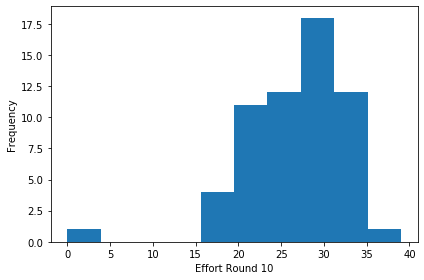

In [5]:
effort_distr_per_round(df_2_pref)

A closer look at the effort distribution per round that there is some variation and a non-neglible amount of subjects choosing zero effort. Yet, the distribution do appear to behave approximately normal.  

/Users/vincentselz/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


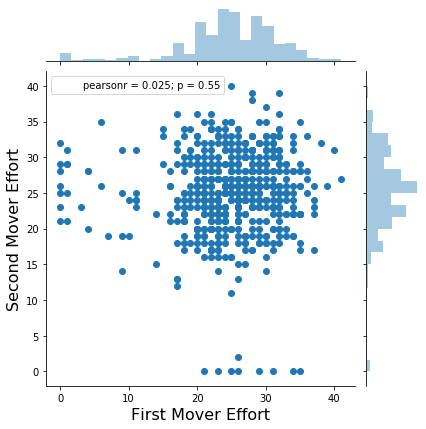

In [6]:
joint_effort(df_2_pref)

As mentioned above, the link that the authors want to investigate is whether the effort $e_1$ of the First Mover negatively impacts the choice of effort $e_2$ made by the Second Mover. A naive strategy is to check for the correlation between those to effort choices. Where disappointment aversion predicts a negative relationship, the canoncal model suggest that there is no link between the effort choices. The correlation suggests that there is little to no correlation, and if at all, they are positively correlated. This positive relationship is suggested by peer effects (Falk and Ichino 2006), where subjects imitate the behavior of their peers and compete by matching or beating the observed effort levels. 

However, this naturally is an insufficient analysis without controlling for any of the other effects on Second Mover effort described in the identification strategy. Thus, next the authors use a reduced form analysis to examine Second Mover's behavior.   

---
## Reduced Form Analysis
---

Given the ten rounds each subject plays that leaves the authors with a panel structure. Here, proposition 1 predicts that when controlling for prize and round effects, the effort of the Second Mover will not depend on the First Mover's effort. In contrast, disappointment aversion predicts a negative relationship. The model to be estimated is:
\begin{equation}
e_{2,n,r} = \beta_1 + \beta_2v_{n,r} + \beta_3e_{1,n,r} + \beta_4e_{1,n,r}  *  v_{n,r} + d_r + \omega_n + \epsilon_{n,r} 
\end{equation}

for   n = 1,...,N and r = 1,...10. Where n denotes the Second Mover and r indicates the paying round. The inclusion of the interaction term is informed by Proposition 3, where the negative effect of the First Mover's effort is larger at higher prizes. Round dummies are included, as well as round-invariant Second Mover effects denoted by $\omega_n$. $\omega_n$ is assumed to be identically and independently distributed over Second Movers with a variance of $\sigma_\omega^2$. $\epsilon_{n,r}$ is an observable that varies over Second Movers, it is also assumed to be identically and independently distributed over rounds and Second Movers with variance $\sigma_\epsilon^2$.

<div class="alert alert-block alert-info">
<b>Note:</b> In the following cells the analysis with R is set up. R is used because using RandomEffects of the linearmodels package does not replicate the results exactly.  
</div>

In [7]:
%%R

# import data 
df <- read_dta("data/paper_data/master_data.dta")

# convert the data frame to a data format recognizable by 'plm' 
pdf <- subset(pdata.frame(df, index = c("Subject", "Period")))
pdf_pref <- subset(pdf, !Subject==302)

# Split interaction term on the first and the last rounds
split <- pdf_pref
split$Period <- as.numeric(split$Period)

#This ensures that we have two different interaction terms
split$last <- ifelse(split$Period <= 5, 0, split$E1timesPrize)
split$first <- ifelse(split$Period > 5, 0, split$E1timesPrize)

In [8]:
%%R

# Random Effects Regressions
re <- plm(Effort~e1+prize+E1timesPrize+TT2+TT3+TT4+TT5+TT6+TT7+TT8+TT9+TT10, data = pdf, model = "random")
re_pref <- plm(Effort~e1+prize+E1timesPrize+TT2+TT3+TT4+TT5+TT6+TT7+TT8+TT9+TT10, data = pdf_pref, model = "random")
# Fixed Effects Regressions
fe <- plm(Effort~e1+prize+E1timesPrize+TT2+TT3+TT4+TT5+TT6+TT7+TT8+TT9+TT10, data = pdf, model = "within")
fe_pref <- plm(Effort~e1+prize+E1timesPrize+TT2+TT3+TT4+TT5+TT6+TT7+TT8+TT9+TT10, data = pdf_pref, model = "within")
# Robustness
re_pref_wo_prices <- plm(Effort~e1+TT2+TT3+TT4+TT5+TT6+TT7+TT8+TT9+TT10, data = pdf_pref, model = "random")
split_interaction <- plm(Effort~e1+prize+last+first+TT2+TT3+TT4+TT5+TT6+TT7+TT8+TT9+TT10, data = split, model = "random")

<div class="alert alert-block alert-success">
    <b>Replication</b> of the parameters and standard errors in Table 2 of the paper.
</div>

In [25]:
%%R

stargazer(re_pref, re, type="text", title="Random Effects Regressions",
          dep.var.labels="Second Mover Effort",
          omit=c("TT2","TT3","TT4","TT5","TT6","TT7","TT8","TT9","TT10"),
          covariate.labels=c("First Mover Effort", "Prize", "Prize x First Mover effort","Intercept"),
          column.labels=c("Preferred Sample", "Full Sample"),
          no.space=TRUE)


Random Effects Regressions
                               Dependent variable:     
                           ----------------------------
                               Second Mover Effort     
                           Preferred Sample Full Sample
                                 (1)            (2)    
-------------------------------------------------------
First Mover Effort              0.044          0.047   
                               (0.049)        (0.049)  
Prize                          1.639***      1.655***  
                               (0.602)        (0.592)  
Prize x First Mover effort     -0.049**      -0.050**  
                               (0.023)        (0.023)  
Intercept                     19.777***      19.392*** 
                               (1.400)        (1.447)  
-------------------------------------------------------
Observations                     590            600    
R2                              0.137          0.135   
Adjusted R2         

Here should the interpretation be

In [10]:
%%R

# Compute the Random Effect Standard Errors of the preferred sample
se_re_pref <- ercomp(re_pref)
se_re_pref

                 var std.dev share
idiosyncratic 14.838   3.852 0.447
individual    18.387   4.288 0.553
theta: 0.7267


In [11]:
%%R

# Compute the Random Effect Standard Errors of the full sample
se_re <- ercomp(re)
se_re

                 var std.dev share
idiosyncratic 14.638   3.826 0.339
individual    28.537   5.342 0.661
theta: 0.7791


some interpretation of the regression parameters 

<div class="alert alert-block alert-info">
<b>Note:</b> The following regression shows the fixed effects regression that is mentioned in the text but not epxlicitly shown. 
</div>

In [12]:
%%R

stargazer(fe_pref,fe, type="text", title="Fixed Effects Regressions",
          dep.var.labels="Second Mover Effort",
          omit=c("TT2","TT3","TT4","TT5","TT6","TT7","TT8","TT9","TT10"),
          covariate.labels=c("First Mover Effort", "Prize", "Prize x First Mover effort","Intercept"),
          column.labels=c("Preferred Sample", "Full Sample"),
          no.space=TRUE)


Fixed Effects Regressions
                                         Dependent variable:              
                           -----------------------------------------------
                                         Second Mover Effort              
                              Preferred Sample           Full Sample      
                                     (1)                     (2)          
--------------------------------------------------------------------------
First Mover Effort                  0.047                   0.050         
                                   (0.050)                 (0.049)        
Prize                             1.716***                1.701***        
                                   (0.605)                 (0.594)        
Prize x First Mover effort        -0.051**                -0.051**        
                                   (0.024)                 (0.023)        
-------------------------------------------------------------------------

### Fixed vs. Random Effects Models

The authors opt to use a random effects linear regression. It is closely related to the fixed effects. Here, the different assumptions made by the two approaches are discussed. This is followed by the replication of the standard error and the Hausman test that can be found in Table 2. 

Both approaches are workhorses when working with panel/cross sectional time series data. The key question distinction between the two models is the assumption about the omitted variables. Implicitly, the random effects model assumes that there are no omitted variables correlated with the explanatory variables. The entities are drawn randomly from a population. If this is accurate, the model yields unbiased results and produces the smallest standard errors. In comparison, the fixed effects model makes no such strong asusmptions about the correlation of ommited variables with the explanatory variables. In fact, the approach can control for omitted variables bias. The subjects serve as their own controls. For this to hold true, the fixed effects has to be time-invariant. However, being able to control for omitted variable bias comes at the cost of producing higher standard errors. 

The **Hausman test** provides a means for comparing those two models. It tests for the independence of $\omega_n$ and the explanatory variables $x_{it}$. It looks as follows:
\begin{equation}
W = \frac{(\tilde\beta_{RE} - \tilde\beta_{FE})^2}{Var(\tilde\beta_{RE}) - Var(\tilde\beta_{FE})} \sim \chi_1^2
\end{equation}

The null hypothesis $H_0$ is that there is no covariance between the explanatory variables and the specific effects is zero. If this hypothesis is rejected, the $H_1$ leaves us with the fixed effects model coefficients as the only consistent coefficients.    


<div class="alert alert-block alert-success">
    <b>Replication</b> of the Hausman test in  Table 2 of the paper.
</div>

In [35]:
%%R

# Hausman Test testing the Random Effects assumption
hausman <- phtest(fe,re)
hausman_pref <- phtest(fe_pref,re_pref)

hausman_pref


	Hausman Test

data:  Effort ~ e1 + prize + E1timesPrize + TT2 + TT3 + TT4 + TT5 +  ...
chisq = 2.6008, df = 12, p-value = 0.9978
alternative hypothesis: one model is inconsistent



<div class="alert alert-block alert-info">
<b>Note:</b> The following regression also uses two different interaction terms but sets the cut at the 4th round instead of the 5th round. This follows from the visual analysis of the effort distribution per round displayed above. 
</div>

In [31]:
%%R

# Split interaction term on the first and the last rounds
new_split <- pdf_pref
new_split$Period <- as.numeric(new_split$Period)

#This ensures that we have two different interaction terms
new_split$last <- ifelse(new_split$Period <= 4, 0, new_split$E1timesPrize)
new_split$first <- ifelse(new_split$Period > 4, 0, new_split$E1timesPrize)

new_interaction_split <- plm(Effort~e1+prize+last+first+TT2+TT3+TT4+TT5+TT6+TT7+TT8+TT9+TT10, data = new_split, model = "random")

stargazer(split_interaction,new_interaction_split, type="text", title="Interaction Term Splits",
          dep.var.labels="Second Mover Effort",
          omit=c("TT2","TT3","TT4","TT5","TT6","TT7","TT8","TT9","TT10"),
          covariate.labels=c("First Mover Effort", "Prize", "Last","First","Intercept"),
          column.labels=c("Split at round 5", "Split at round 4"),
          no.space=TRUE)


Interaction Term Splits
                          Dependent variable:       
                   ---------------------------------
                          Second Mover Effort       
                   Split at round 5 Split at round 4
                         (1)              (2)       
----------------------------------------------------
First Mover Effort      0.044            0.043      
                       (0.049)          (0.050)     
Prize                  1.640***         1.619***    
                       (0.604)          (0.605)     
Last                   -0.047**         -0.050**    
                       (0.024)          (0.024)     
First                  -0.050**         -0.046*     
                       (0.024)          (0.025)     
Intercept             19.843***        19.687***    
                       (1.415)          (1.416)     
----------------------------------------------------
Observations             590              590       
R2                   

Using a different break point, where the interaction term the first four rounds is denoted by First and the last six rounds are denoted by Last. Does not affect the model much. Although, in the new specification the interaction for the first round is not significant at a 5% level anymore, inspecting the coefficients does not lead to any new conclusions. Now, the last rounds have a larger negative effect than the first round, yet the differences are minor and the test below affirms that the difference is not significant. 

In [34]:
%%R

# Test equality of the interaction term for the first and the last five rounds.
linearHypothesis(split_interaction, c("first=last"))

# Test for equality of the split interaction term with a break at round 4
linearHypothesis(new_interaction_split, c("first=last"))

Linear hypothesis test

Hypothesis:
- last  + first = 0

Model 1: restricted model
Model 2: Effort ~ e1 + prize + last + first + TT2 + TT3 + TT4 + TT5 + 
    TT6 + TT7 + TT8 + TT9 + TT10

  Res.Df Df  Chisq Pr(>Chisq)
1    577                     
2    576  1 0.1868     0.6656


## Structural Model

### Empirical Specification
After not accumulating convincing evidence of disappointment aversion in the reduced form analysis the authors turn to structural estimation strategies. Thanks to the variations induced by the experimental design, the data is well-suited for such an analysis. Beyond, the estimation of disappointment aversion, this approach also allows for the estimation of the population-level heterogeneity.

This leads them to the following specifications:

\begin{equation}
\lambda_{2,n} \sim N(\tilde\lambda_2,sigma_\lambda^2)
\end{equation}
for n = 1,...,N.

Here, $\lambda$ is held fixed on the subject-level. It can vary throughout Second Movers but does not vary over rounds. In addition to $\lambda$ the convexity parameter $c_{n,r}$ is estimated. It is estimated at round and subject-level, making this task a dynamic one. 

\begin{equation}
c_{n,r} = \kappa + \delta_r + \mu_n + \pi_{n,r}
\end{equation}
for n = 1,...,N; r = 1,...10.

$\kappa$ is represents a component common across all Second Movers. $\delta_n$ denotes the round effects that allow the marginal costs of effort to vary rounds. For instance, if due to learning the tasks gets easier in the later periods $\delta_r$ is negative and decreasing over rounds. $\mu_n$ indicates the unobserved differences in the cost of effort on the subject-level that are constant over rounds. $\pi_{n,r}$ denotes the unobserved differences that vary over rounds and Second Movers. For $\pi$ and $\mu$ both scale and shape paramters of a Weibull distribution are estimated. The reasoning for opting for a Weibull distribution is that it has positive support allowing to impose convex cost of effort function on all subjects. In total, this leaves them with the following 17 unknown parameter:  

In [15]:
params_description()

values  \
category       name                 
lambda         lambda     NaN       
               std_lambda NaN       
cost_of_effort phi_pi     NaN       
               varphi_pi  NaN       
               phi_mu     NaN       
               varphi_mu  NaN       
               kappa      NaN       
               b          NaN       
               delta      NaN       

                                                                                                                comment  
category       name                                                                                                      
lambda         lambda      strength of disappointment aversion on average                                                
               std_lambda  standard deviation of strength of disappointment aversion                                     
cost_of_effort phi_pi      unobserved differences in cost of effort functions that vary over rounds and individuals      
               varphi_pi   unobserved differences in cost of effort functions that vary over rounds and individuals      
               phi_mu      unobserved differences in cost of effort functions between individuals, constant over rounds  
               varphi_mu   unobserved differences in cost of effort functions between individuals, constant over rounds  
               kappa       common cost parameter                                                                         
               b           common cost parameter                                                                         
               delta       round effects for round 2,...N

### Method of Simulated Moments

The parameter of interest are estimated by the **Method of Simulated Moments (MSM)** that was pioneered by McFadden (1989) and by Pakes and Pollard (1989). The idea is, similar to the Generalized Method of Moments (GMM), to use a vector of moments M with $k \geq 17$, where every included moments is dependent on the endogenous variables. 

The step that differentiates MSM from GMM is the use of simulated samples. In each of the S simulated sample the Second Mover face the same przes and First Mover effort as observed in the actual sample. The behavior of the Second Movers in the simulated sample is guided by the trial  $\theta_t$ values of the unknown parameters $\theta$. The unobservables $\mu$ and $\pi$ are assigned to the Second Movers with the specified distributions. 

For all Second Movers and each round the utility for all 48 possible effort choices is computed and the simulated action corresponds to the effort choice with the highest achieved utility. In order to compare the simulated samples to the experimental sample the vector of moments $M_s(\theta_t)$ are computed. These moments are used in the following metric:

\begin{equation*}
J(\theta_t) =  \left(M - \frac{1}{S} \sum\limits_{S=1}^S M_S(\theta_t)\right)'W_N\left(M - \frac{1}{S} \sum\limits_{S=1}^S M_S(\theta_t)\right) 
\end{equation*}

This is the core function of the MSM approach. The objective of this metric is $J(\theta_t): \hat\theta = arg min_{\theta_t} J(\theta_t)$. It minimizes the distance between the average of the simulated sample and the experimental sample. Thus, the moments induced by the structural parameters have to be as close to the actual moments as possible. $W_N$ is the weighting matrix of $k x k$ dimension. For this simulation, the authors specify the diagonal elements of the weigthing matrix as the inverse of N times the bootstrapped variance of the moments and zeroes on the non-diagonal elements. In total, 38 moments are used to estimate the 17 unknown parameters.   

### Empirical Moments

In order to estimate the parameters that are of interest, moments need to be simulated. A dataframe fashioned after Table 4 is provided below. It gives an overview over the moments the authors choose to be estimated. 

<div class="alert alert-block alert-success">
    <b>Replication</b> of the descriptions in Table 4.
</div>

In [16]:
moments_description()

,comment
name,
cond_corr_e2_prize,"correlation of e2 and prize, conditional on control effects"
cond_corr_e2_e1,"correlation of e2 and e1, conditional on control effects"
cond_corr_e2_e1timesprize,"correlation of e2 and e1 * prize, conditional on control effects"
low_effort_low_prize,effort conditional on low e2 and low prizes
low_effort_high_prize,effort conditional on low e2 and high prizes
high_effort_high_prize,effort conditional on high e2 and high prizes
effort_std,standard deviation of effort
low_effort_prop,probability of low effort
high_effort_prop,probability of high effort


Naturally, the functions needed to compute the above moments need to be stored. They are stored in the dictionary. There are separate functions for all those moments, eventhough a lot have similarities with each other. This was done to follow the guides outlined on the *respy* website as closely as possible. 

In [17]:
calc_moments = {
    'effort_std': effort_std,
    'corr_round_lag1': pooled_autocorr_lag1,
    'corr_round_lag2': pooled_autocorr_lag2,
    'round_change_std': round_change_std,
    'mean_period_1': period1_average,
    'mean_period_2': period2_average,
    'mean_period_3': period3_average,
    'mean_period_4': period4_average,
    'mean_period_5': period5_average,
    'mean_period_6': period6_average,
    'mean_period_7': period7_average,
    'mean_period_8': period8_average,
    'mean_period_9': period9_average,
    'mean_period_10': period10_average,
    'cond_corr_e2_prize': cond_corr_e2_prize,
    'cond_corr_e2_e1': cond_corr_e2_e1,
    'cond_corr_e2_e1timesprize': cond_corr_e2_e1timesprize,
    'perc17_cond_corr_e2_prize': perc17_cond_corr_e2_prize,
    'perc33_cond_corr_e2_prize': perc33_cond_corr_e2_prize,
    'perc50_cond_corr_e2_prize': perc50_cond_corr_e2_prize,
    'perc66_cond_corr_e2_prize': perc66_cond_corr_e2_prize,
    'perc83_cond_corr_e2_prize': perc83_cond_corr_e2_prize,
    'perc17_cond_corr_e2_e1': perc17_cond_corr_e2_e1,
    'perc33_cond_corr_e2_e1': perc33_cond_corr_e2_e1,
    'perc50_cond_corr_e2_e1': perc50_cond_corr_e2_e1,
    'perc66_cond_corr_e2_e1': perc66_cond_corr_e2_e1,
    'perc83_cond_corr_e2_e1': perc83_cond_corr_e2_e1,
    'perc17_cond_corr_e2_e1timesprize': perc17_cond_corr_e2_e1timesprize,
    'perc33_cond_corr_e2_e1timesprize': perc33_cond_corr_e2_e1timesprize,
    'perc50_cond_corr_e2_e1timesprize': perc50_cond_corr_e2_e1timesprize,
    'perc66_cond_corr_e2_e1timesprize': perc66_cond_corr_e2_e1timesprize,
    'perc83_cond_corr_e2_e1timesprize': perc83_cond_corr_e2_e1timesprize,
    'low_effort_low_prize': low_effort_low_prize,
    'low_effort_high_prize': low_effort_high_prize,
    'high_effort_low_prize': high_effort_low_prize,
    'high_effort_high_prize': high_effort_high_prize,
    'low_effort_prop': low_effort_prop,
    'high_effort_prop': high_effort_prop
}

These function, in turn, are used to compute the empirical moments. These are the moments that are computed with the experimental sample without any simulation. Here, my results do not match the authors observed moments precisely. A closer discussion about the divergences follows below. 

<div class="alert alert-block alert-warning">
    <b>Replication</b> of the observed moments in Table 5.
</div>

In [21]:
observed_moments(df_2_pref)

{'effort_std': 5.8745832443237305,
 'corr_round_lag1': 0.6523300435833547,
 'corr_round_lag2': 0.5955089258400272,
 'round_change_std': 4.82824351834171,
 'mean_period_1': 21.762712478637695,
 'mean_period_2': 23.457626342773438,
 'mean_period_3': 24.830509185791016,
 'mean_period_4': 25.20339012145996,
 'mean_period_5': 25.11864471435547,
 'mean_period_6': 24.898305892944336,
 'mean_period_7': 25.762712478637695,
 'mean_period_8': 26.169490814208984,
 'mean_period_9': 26.25423812866211,
 'mean_period_10': 26.72881317138672,
 'cond_corr_e2_prize': 0.12361415759953642,
 'cond_corr_e2_e1': 0.04149206717166187,
 'cond_corr_e2_e1timesprize': -0.09501348232241316,
 'perc17_cond_corr_e2_prize': -0.27105945532213094,
 'perc33_cond_corr_e2_prize': 0.03403581380424789,
 'perc50_cond_corr_e2_prize': 0.22225342393899755,
 'perc66_cond_corr_e2_prize': 0.39185221079267774,
 'perc83_cond_corr_e2_prize': 0.4740481839263494,
 'perc17_cond_corr_e2_e1': -0.31438149865867704,
 'perc33_cond_corr_e2_e1': -

Two types of functions are diverging from the results of the paper. First, the percentiles of the Second Mover specific correlations and, surprisingly, the mean effort conditional on high/low prices and First Mover efforts. 

The computed percentiles are close to the ones in the paper. It appears difference methods in rounding contribute to those differences.   

The means in the table are misspecified. Whereas Table 5 states that the specified effort and prizes needs to be strictly higher or lower, their function uses non-strict inequality. The respective functions can be found in subdirectory MatLabCode under moments.m line 168 and following. They use the *sign* function to indicate when prices are higher or efforts are higher thant the respective threshold. These are subsequently deleted. Yet, still leaving the Seond Mover efforts that are equal to the threshold in to compute the mean. **This should probably not belong in here.**

Another result, the autocorrelation, uses the pooled variance, which leads to a higher composite autocorrelation. Is this bad?

### Trial values

In [64]:
trial_values = trial_values()
trial_values

,name,values
0,lambda,2.00
1,std_lambda,1.50
2,phi_pi,0.35
3,varphi_pi,0.85
4,phi_mu,0.35
5,varphi_mu,0.85
6,kappa,1.75
7,b,NaN
8,delta2,0.00
9,delta3,0.00


### Weighting Matrix

The diagonal elements of the weighting matrix are the inverse of N times the variances of the sample moments and zeros elsewhere. Bootstrap sampling with replacement is used to compute $W_n$. Thankfully, this is the same strategy pursued in the *respy* documentation.

In [37]:
#weighting_matrix = get_weighting_matrix(data=df_2_pref,empirical_moments=data, calc_moments=calc_moments, n_bootstrap_samples=2000, n_observations_per_sample=59, replace_missing_variances=None)

## Critical Assessment

The saying is that when having a well designed experiment, the following empirical analysis to identify the targeted effect is simple. This experiments turns this saying around and shows that structural models can help overcome difficulties in identifying such causal effects. Here, the use of structural estimation salvaged the situation. Results of the reduced form evidence provided little to no evidence for disappointment aversion. The interaction term between First Mover effort and prize was significant but the main variable of interest, the sole First Mover effort, was not. 


In general, I would argue that the experiment was not well suited for the identification. The highly significant dummy variables for round effects in the reduced form analysis, suggest that the design did pick up various confounds that were not intended. The significant negative $\delta_r$ in the structural estimation corroborates that learning, in fact, did take place through the paying rounds. The experimenters did set up two training rounds, yet it appears this was not enough. Expanding the training rounds might help filter these confounds out of experimental sample. 

The empirical analysis by the authors is sound and well justified. In their structural model, they test various specifications that would favor explanations other than disappointment aversion. Unfortunately, I was not able to reproduce the MSM, else I could have commented more extensively on the intrinsic of those specifications.  